In [243]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import time
import random


In [244]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

SEED = 42
set_seed(SEED)


In [245]:
env = gym.make("CartPole-v1")


In [246]:
# Define number of bins per feature
n_bins = [6, 6, 12, 12]  # example: fewer bins for velocity, more for angle
# n_bins = [2, 2, 3, 3]  # example: fewer bins for velocity, more for angle
# n_bins = [2, 2, 3, 3]

# State bounds
state_low = env.observation_space.low
state_high = env.observation_space.high

# Cap some unbounded features (CartPole velocity is ±inf)
state_low[1] = -3.0
state_high[1] = 3.0
state_low[3] = -3.0
state_high[3] = 3.0

def discretize_state(obs):
    ratios = (obs - state_low) / (state_high - state_low)
    ratios = np.clip(ratios, 0, 0.9999)
    bins = [int(r * n) for r, n in zip(ratios, n_bins)]
    return tuple(bins)


In [247]:
TERMINAL = tuple([-1]*4)  # unique state for all terminal transitions


In [248]:
n_samples = 100_000
n_samples2 = 100_000

# n_samples = 100
# n_samples2 = 100

In [249]:
def estimate_cartpole_transitions(env, n_samples=n_samples):
    P = {}
    R = {}
    
    for s in range(n_samples):
        start_time = time.time()
        obs, _ = env.reset()
        done = False
        while not done:
            s = discretize_state(obs)
            a = env.action_space.sample()  # random for coverage
            next_obs, r, terminated, truncated, _ = env.step(a)
            s2 = discretize_state(next_obs) if not (terminated or truncated) else TERMINAL

            # Count transitions
            P.setdefault((s, a), {})
            P[(s, a)][s2] = 1  # deterministic
            
            # Rewards
            R[(s, a)] = 1.0  # reward is always 1 per step
            obs = next_obs
            done = terminated or truncated


    return P, R

P, R = estimate_cartpole_transitions(env, n_samples=n_samples2)


In [250]:
def value_iteration(states, actions, P, R, gamma=0.99, delta=1e-4, patience=3):
    V = {s:0.0 for s in states}
    V[TERMINAL] = 0.0
    best_policy = {s:0 for s in states}
    
    deltas = []
    no_improve = 0

    while True:
        max_diff = 0
        V_new = {}
        for s in states:
            if s == TERMINAL:
                V_new[s] = 0.0
                continue

            q_vals = []
            for a in actions:
                q = R.get((s,a), 0)
                if (s,a) in P:
                    for s2,p in P[(s,a)].items():
                        q += gamma * p * V.get(s2,0)
                q_vals.append(q)

            V_new[s] = max(q_vals)
            best_policy[s] = np.argmax(q_vals)
            max_diff = max(max_diff, abs(V_new[s] - V.get(s,0)))
        V = V_new
        deltas.append(max_diff)

        if max_diff < delta:
            no_improve += 1
        else:
            no_improve = 0

        if no_improve >= patience:
            break

    return V, best_policy, deltas


In [251]:
from itertools import product

states = list(product(*(range(n) for n in n_bins)))
states.append(TERMINAL)
actions = [0, 1]


In [252]:
start = time.time()
V_vi, pi_vi, deltas_vi = value_iteration(states, actions, P, R)
vi_time = time.time() - start
print(f"VI finished in {vi_time:.2f}s")


VI finished in 35.83s


/home/justin/miniforge3/envs/sl_report_env/lib/python3.13/site-packages/matplotlib/scale.py:255: RuntimeWarning: overflow encountered in power
  return np.power(self.base, values)


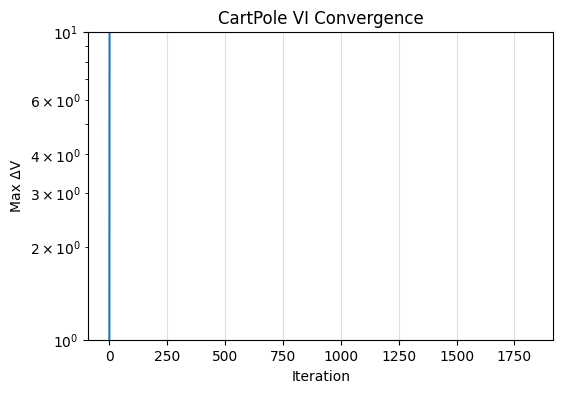

In [253]:
plt.figure(figsize=(6,4))
plt.plot(deltas_vi)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Max ΔV')
plt.title('CartPole VI Convergence')
plt.grid(True, alpha=0.4)
plt.savefig("Cartpole_VI_Convergence.pdf")
plt.show()


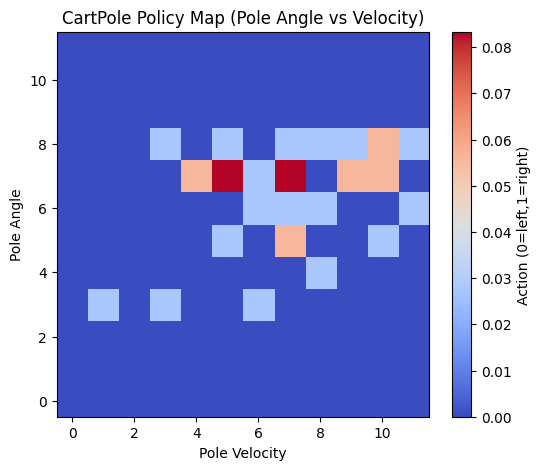

In [254]:
import numpy as np

angle_idx = 2
ang_vel_idx = 3

policy_map = np.zeros((n_bins[angle_idx], n_bins[ang_vel_idx]))
counts = np.zeros((n_bins[angle_idx], n_bins[ang_vel_idx]))

for s, a in pi_vi.items():
    if s == TERMINAL:
        continue
    policy_map[s[angle_idx], s[ang_vel_idx]] += a
    counts[s[angle_idx], s[ang_vel_idx]] += 1

policy_map = np.divide(policy_map, counts, out=np.zeros_like(policy_map), where=counts!=0)

plt.figure(figsize=(6,5))
plt.imshow(policy_map, origin='lower', aspect='auto', cmap='coolwarm')
plt.colorbar(label='Action (0=left,1=right)')
plt.xlabel('Pole Velocity')
plt.ylabel('Pole Angle')
plt.title('CartPole Policy Map (Pole Angle vs Velocity)')
plt.savefig("CartPole_Policy_Map.pdf")
plt.show()


In [255]:
n_samples3=30_000
# n_samples3=2000

In [256]:
print([x for x in range(30,60,6)])

[30, 36, 42, 48, 54]


In [257]:

seed_list = range(30,60,6)
wall_clocks = []

for seed in seed_list:
    print(seed)
    set_seed(seed)
    start = time.time()
    P_seed, R_seed = estimate_cartpole_transitions(env, n_samples=n_samples3)  # stochastic approximation
    V, pi, deltas = value_iteration(states, actions, P_seed, R_seed)
    wall_clocks.append(time.time()-start)
    print(f"_ In {round(wall_clocks[-1],2)}s")

print(f"Mean wall-clock per seed: {np.mean(wall_clocks):.2f}s, total: {np.sum(wall_clocks):.2f}s")


30
_ In 63.68s
36
_ In 58.91s
42
_ In 49.44s
48
_ In 58.8s
54
_ In 51.53s
Mean wall-clock per seed: 56.47s, total: 282.36s


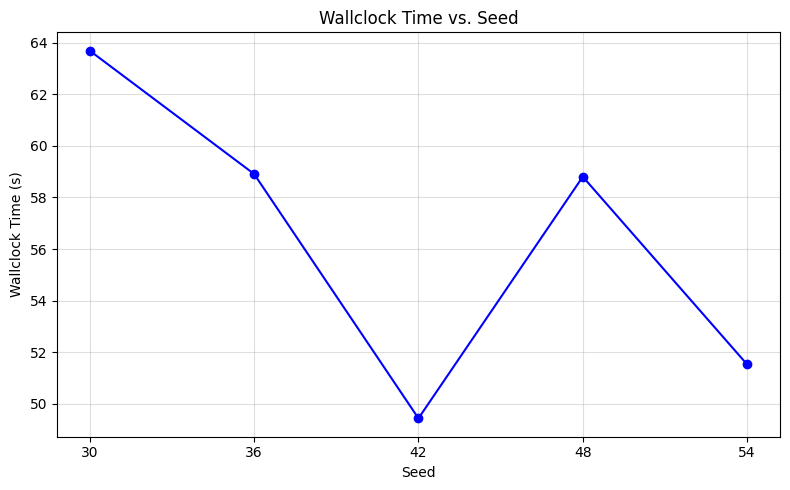

In [258]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(seed_list, wall_clocks, marker='o', linestyle='-', color='b')
plt.xlabel('Seed')
plt.ylabel('Wallclock Time (s)')
plt.title('Wallclock Time vs. Seed')
plt.grid(True, alpha = 0.4)
plt.xticks(seed_list)
plt.tight_layout()

# Save the plot
plt.savefig('wallclock_vs_seed.pdf')
# plt.close()

# Display the plot (if in a notebook or interactive environment)
plt.show()